# Kaggle login, data download

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyonukjo","key":"c809a350a55c435ea7448c20610ab419"}'}

In [ ]:
!ls -1ha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c 5th-goorm-project-1-text-classification

  0% 0.00/6.12M [00:00<?, ?B/s]
100% 6.12M/6.12M [00:00<00:00, 93.6MB/s]


In [ ]:
from zipfile import ZipFile
# 데이터 경로
data_path = '/content/'

with ZipFile(data_path + '5th-goorm-project-1-text-classification.zip') as zipper:
    zipper.extractall()

# Import requirements

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.1 MB/s eta 0:00:00


In [ ]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AutoConfig,
    AdamW
)

# 1. Preprocess

In [ ]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
            #CLS/SEP은 encoding시 자동으로 들어가게 됨.
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
!ls

5th-goorm-project-1-text-classification.zip  sentiment.dev.1
kaggle.json				     sentiment.train.0
sample_data				     sentiment.train.1
sentiment.dev.0				     test_no_label.csv


In [ ]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [ ]:
train_pos[:10]

['0 3463 39462 689 479 50118 2',
 '0 16101 428 2111 544 479 50118 2',
 '0 10010 67 33 1230 24827 8 2480 6353 61 16 269 205 479 50118 2',
 '0 405 128 29 10 205 7 14317 9379 1073 324 479 50118 2',
 '0 627 813 16 5192 479 50118 2',
 '0 8396 2003 689 479 50118 2',
 '0 8396 544 479 50118 2',
 '0 29 18615 9 183 16 17798 8 3739 9 24827 479 50118 2',
 '0 12338 317 13 4592 50 2003 14967 8 4437 479 50118 2',
 '0 627 92 1186 1326 2770 479 50118 2']

In [ ]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [ ]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [ ]:
print(len(list(train_dataset)))
print(len(list(dev_dataset)))

443259
4000


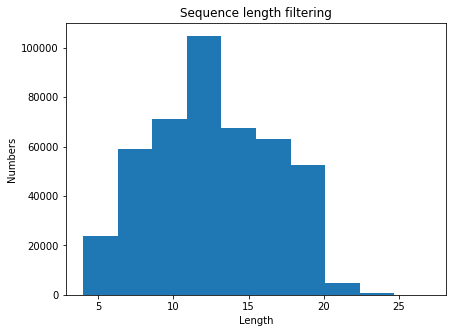

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)     
plt.hist([len(i[0]) for i in list(train_dataset)+list(dev_dataset)])
plt.title('Sequence length filtering')
plt.xlabel('Length')
plt.ylabel('Numbers')
plt.show()

In [ ]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    0,  3463, 39462,   689,   479, 50118,     2]), array([1]))
(array([    0, 16101,   428,  2111,   544,   479, 50118,     2]), array([1]))
(array([    0, 10010,    67,    33,  1230, 24827,     8,  2480,  6353,
          61,    16,   269,   205,   479, 50118,     2]), array([1]))
(array([    0,   405,   128,    29,    10,   205,     7, 14317,  9379,
        1073,   324,   479, 50118,     2]), array([1]))
(array([    0,   627,   813,    16,  5192,   479, 50118,     2]), array([1]))
(array([    0,  8396,  2003,   689,   479, 50118,     2]), array([1]))
(array([    0,  8396,   544,   479, 50118,     2]), array([1]))
(array([    0,    29, 18615,     9,   183,    16, 17798,     8,  3739,
           9, 24827,   479, 50118,     2]), array([1]))
(array([    0, 12338,   317,    13,  4592,    50,  2003, 14967,     8,
        4437,   479, 50118,     2]), array([1]))
(array([    0,   627,    92,  1186,  1326,  2770,   479, 50118,     2]), array([1]))
(array([    0,  9226,   317,    21,   

In [ ]:
def collate_fn_style(samples):
    #Padding을 통해 길이 맞춰주기
    #samples는 batch size의 input이다.
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    #Batch_size에서 가장 긴 것이 무엇이냐?
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    #Batch를 길이순으로 정렬하기
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [ ]:
train_batch_size=32
eval_batch_size=64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=False, collate_fn=collate_fn_style,
                                         num_workers=2)

In [ ]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
model.train()
learning_rate = 3e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [24]:
train_epoch = 3
lowest_valid_loss = 9999.
validation_loss = []
accuracy = []
patience=6
early_stop=False
for epoch in range(train_epoch):
    if early_stop:
        break
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            if early_stop:
                break
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)
            optimizer.zero_grad()

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 10) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       position_ids=position_ids,
                                       labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)
                accuracy.append(acc)
                validation_loss.append(valid_loss)
                if lowest_valid_loss > valid_loss:
                    lowest_valid_loss=valid_loss
                    print('Acc for model which have lower valid loss: ', acc)
                else:
                    patience-=1  
                    print("overfit?")  
                    if patience<0:
                        print("Oops")
                        early_stop=True
                
                torch.save(model.state_dict(), "./pytorch_model.bin")


Eval: 100%|██████████| 63/63 [00:04<00:00, 13.85it/s]
                                                     

Acc for model which have lower valid loss:  0.9675


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.17it/s]
                                                     

Acc for model which have lower valid loss:  0.96925


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.13it/s]
                                                     

overfit?


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.08it/s]
                                                     

Acc for model which have lower valid loss:  0.96825


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.07it/s]
                                                     

Acc for model which have lower valid loss:  0.9705


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.26it/s]
                                                     

overfit?


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.11it/s]
                                                     

overfit?


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s]
                                                     

overfit?


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.29it/s]
                                                     

Acc for model which have lower valid loss:  0.9695


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s]
                                                     

Acc for model which have lower valid loss:  0.97125


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.06it/s]
                                                     

Acc for model which have lower valid loss:  0.975


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.10it/s]
                                                     

overfit?


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.38it/s]
                                                     

overfit?


Eval: 100%|██████████| 63/63 [00:04<00:00, 14.28it/s]
                                                     

overfit?
Oops


Epoch 1:  40%|████      | 5541/13852 [13:41<20:32,  6.74batch/s, loss=0.221]  


In [ ]:
# train_epoch = 3
# lowest_valid_loss = 9999.
# validation_loss = []
# accuracy = []
# for epoch in range(train_epoch):
#     with tqdm(train_loader, unit="batch") as tepoch:
#         for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
#             tepoch.set_description(f"Epoch {epoch}")
#             input_ids = input_ids.to(device)
#             attention_mask = attention_mask.to(device)
#             token_type_ids = token_type_ids.to(device)
#             position_ids = position_ids.to(device)
#             labels = labels.to(device, dtype=torch.long)
#             optimizer.zero_grad()

#             output = model(input_ids=input_ids,
#                            attention_mask=attention_mask,
#                            token_type_ids=token_type_ids,
#                            position_ids=position_ids,
#                            labels=labels)

#             loss = output.loss
#             loss.backward()

#             optimizer.step()

#             tepoch.set_postfix(loss=loss.item())
#             if iteration != 0 and iteration % int(len(train_loader) / 6) == 0:
#                 # Evaluate the model five times per epoch
#                 with torch.no_grad():
#                     model.eval()
#                     valid_losses = []
#                     predictions = []
#                     target_labels = []
#                     for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
#                                                                                                 desc='Eval',
#                                                                                                 position=1,
#                                                                                                 leave=None):
#                         input_ids = input_ids.to(device)
#                         attention_mask = attention_mask.to(device)
#                         token_type_ids = token_type_ids.to(device)
#                         position_ids = position_ids.to(device)
#                         labels = labels.to(device, dtype=torch.long)

#                         output = model(input_ids=input_ids,
#                                        attention_mask=attention_mask,
#                                        token_type_ids=token_type_ids,
#                                        position_ids=position_ids,
#                                        labels=labels)

#                         logits = output.logits
#                         loss = output.loss
#                         valid_losses.append(loss.item())

#                         batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
#                         batch_labels = [int(example) for example in labels]

#                         predictions += batch_predictions
#                         target_labels += batch_labels

#                 acc = compute_acc(predictions, target_labels)
#                 valid_loss = sum(valid_losses) / len(valid_losses)
#                 if lowest_valid_loss > valid_loss:
#                     print('Acc for model which have lower valid loss: ', acc)
#                     accuracy.append(acc) # accuracy 값 저장
#                     validation_loss.append(valid_loss) # validation loss 값 저장
#                     torch.save(model.state_dict(), "./pytorch_model.bin")

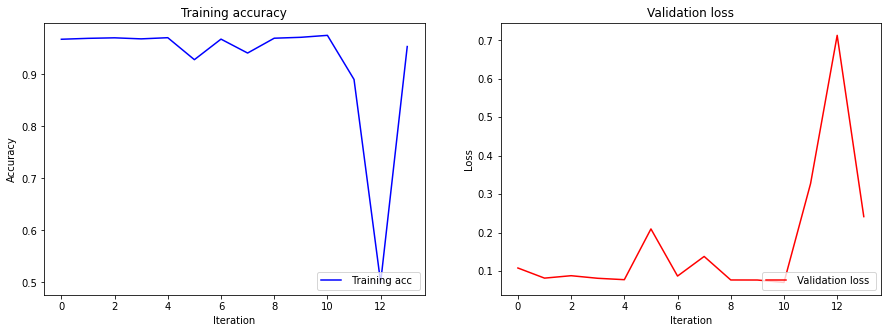

In [25]:
# visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)     
plt.plot(accuracy, label=' Training acc ', color ='b')
plt.title('Training accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(validation_loss, label=' Validation loss ', color = 'r')
plt.title('Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [26]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [27]:
test_dataset = test_df['Id']

In [28]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [29]:
test = make_id_file_test(tokenizer, test_dataset)

In [30]:
test[:10]

['0 405 128 29 10 1086 92 676 8 92 14250 349 86 47 213 479 2',
 '0 2527 6770 31 41 793 2674 479 2',
 '0 405 16 5 144 12757 3553 1439 11 5 15044 479 2',
 '0 5016 45 1203 10 7792 19 209 82 479 2',
 '0 118 21 7464 8 79 156 162 619 98 3473 8 2814 479 2',
 '0 627 129 631 52 829 14 21 2131 21 5 3895 479 2',
 '0 2362 2156 45 5 1980 23 25 257 2156 5 1980 11 3812 239 479 2',
 '0 10010 836 24 66 760 13 47 8 32 182 7163 479 2',
 '0 7269 5 22633 222 295 75 190 216 141 7 173 5 3034 479 2',
 '0 10010 33 41 4206 4230 9 44505 7 2807 31 479 2']

In [31]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [32]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [33]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in range(len(samples))],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in range(len(samples))])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in range(len(samples))])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in range(len(samples))])

    return input_ids, attention_mask, token_type_ids, position_ids

In [34]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [35]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        output = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       position_ids=position_ids)

        logits = output.logits
        logits = [torch.argmax(example).cpu().numpy() for example in logits]
        predictions += logits


Test:  91%|█████████ | 29/32 [00:01<00:00, 26.97it/s]
                                                     

In [36]:
test_df['Category'] = predictions

In [38]:
test_df.to_csv('./submission.csv', index=False)